[TODO: Add section about del_r between leptons/jets.]

<h1>PyHEP 2020: A Practical Analysis in Coffea</h1>
<p>[TODO: Authors]</p>
<hr />
<h2>Introduction</h2>
<p>This tutorial will be going through a practical analysis (single top-Higgs production) done in Coffea. The cuts demanded by the analysis, as well as how they are implemented in Coffea, will first be detailed step-by-step. At the end, these steps will be wrapped up in the Coffea processor class, and I will run on a Dask cluster premiered earlier this week by Oksana Shadura with real CMS data, as a proof of Coffea deployment.</p>


<h2>Review(?)</h2>
<p>We begin by loading in a sample file used in the analysis, and the NanoEvents package within Coffea.</p>

In [1]:
try:
    import numpy as np
except ImportError as e:
    !pip install numpy
    import numpy as np

try:
    from coffea.nanoaod import NanoEvents
except ImportError as e:
    !conda install -c conda-forge xrootd --yes
    !pip install coffea
    from coffea.nanoaod import NanoEvents
    
try:
    import numba as nb
except ImportError as e:
    !pip install numba
    import numba as nb

import time

start = time.time()
file = "root://xrootd.unl.edu//store/mc/RunIISummer16NanoAODv5/THQ_Hincl_13TeV-madgraph-pythia8_TuneCUETP8M1/NANOAODSIM/PUMoriond17_Nano1June2019_102X_mcRun2_asymptotic_v7-v1/100000/38E83594-51BD-7D46-B96D-620DD60078A7.root"
events = NanoEvents.from_file(file)

<p>This loads in the test file in events, which has a jagged array structure that stores all of the file's events. We can see what attributes the events have by calling the .columns attribute.</p>

In [2]:
print(events)
print('\n')
print(events.columns)

[<event 0> <event 1> <event 2> ... <event 614397> <event 614398> <event 614399>]


['GenDressedLepton', 'btagWeight', 'GenJet', 'Flag', 'PV', 'PuppiMET', 'SoftActivityJetNjets5', 'TrigObj', 'PSWeight', 'OtherPV', 'Muon', 'SoftActivityJetHT', 'genTtbarId', 'SoftActivityJetNjets2', 'L1', 'CaloMET', 'L1PreFiringWeight', 'L1simulation', 'Generator', 'SoftActivityJetHT2', 'fixedGridRhoFastjetAll', 'HLT', 'ChsMET', 'HLTriggerFirstPath', 'Electron', 'LHEPdfWeight', 'LHEWeight', 'SoftActivityJetNjets10', 'fixedGridRhoFastjetCentralCalo', 'genWeight', 'SoftActivityJet', 'Tau', 'LHE', 'SoftActivityJetHT5', 'HTXS', 'LHEScaleWeight', 'GenPart', 'fixedGridRhoFastjetCentralNeutral', 'SV', 'SubGenJetAK8', 'fixedGridRhoFastjetCentral', 'run', 'CorrT1METJet', 'TkMET', 'LHEPart', 'luminosityBlock', 'IsoTrack', 'Photon', 'SoftActivityJetHT10', 'HLTriggerFinalPath', 'RawMET', 'GenVisTau', 'Jet', 'MET', 'LHEReweightingWeight', 'Pileup', 'SubJet', 'GenMET', 'GenJetAK8', 'event', 'fixedGridRhoFastjetCentralC

And we can easily access any of those attributes. For example, 'Muon':

In [3]:
events.Muon

<MuonArray [[<Muon 0> <Muon 1>] [] [<Muon 2>] ... [<Muon 622043> <Muon 622044>] [<Muon 622045>] [<Muon 622046>]] at 0x7f9968433cd0>

<p>And, similarly, we can easily access any of the attributes that the 'Muon' column has (for example, pt):</p>

In [4]:
print(events.Muon.columns)
print('\n')
print(events.Muon.pt)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[48.43083 32.657864] [] [61.244366] ... [6.901195 6.2357697] [68.91875] [3.0041604]]


Now, an important component of columnar analysis is the concept of masking. We can mask an array with some condition, which returns to us an array of the same shape, but filled with True/False, based on whether each element in that array meets the condition or not. We can apply this mask to the original array to 'kick out' all the False statements, leaving us with True's. For example, say we want muons with pt > 40:

In [5]:
muons = events.Muon

print(muons)
print('\n')
print(muons.pt)
print('\n')
print(muons[muons.pt > 40])

[[<Muon 0> <Muon 1>] [] [<Muon 2>] ... [<Muon 622043> <Muon 622044>] [<Muon 622045>] [<Muon 622046>]]


[[48.43083 32.657864] [] [61.244366] ... [6.901195 6.2357697] [68.91875] [3.0041604]]


[[<Muon 0>] [] [<Muon 2>] ... [] [<Muon 622045>] []]


<p>As you can see above, the first subarray of Muon has two muons, one of which has pt > 40, and the other of which doesn't. In the last line, we see that the one which doesn't has been booted out, and we're left with the ones we want. Easy!</p>

<h2>Lepton Selection</h2>
<p>So, after that review, let's now begin with some lepton selection, for which the Muon column we've selected to view above is a perfect fit. Borrowing from the draft note of [TODO: CITATION HERE], we're provided these requirements for muons:</p>

| Cut                      | Loose        | Tight        |
|--------------------------|--------------|--------------|
| $\eta$ < 2.4             | $\checkmark$ | $\checkmark$ |
| $p_T$                    | > 5 GeV      | > 15 GeV     |
| \|$d_{xy}$\| < 0.05 (cm) | $\checkmark$ | $\checkmark$ |
| \|$d_z$\| < 0.1 (cm)     | $\checkmark$ | $\checkmark$ |
| SIP$_{3D}$ < 8           | $\checkmark$ | $\checkmark$ |
| I$_{mini}$ < 0.4         | $\checkmark$ | $\checkmark$ |
| is Loose Muon            | $\checkmark$ | $\checkmark$ |
| jet CSV                  | -            | < 0.8484     |
| is Medium Muon           | -            | $\checkmark$ |
| tight-charge             | -            | $\checkmark$ |
| lepMVA > 0.90            | -            | $\checkmark$ |

How would we make these cuts in a columnar fashion? Almost exactly the same way as printed, actually! All we have to do is mask the Muon array with a boolean array that represents muons which pass the loose cuts (in one case) and tight cuts (in the other). The only intermediate step is figuring out column labels; I've left in an extra cell if you want to poke at a specific column's structure:

In [6]:
print(muons.columns)
print('\n')
print(muons.mediumId)

['dxy', 'dxyErr', 'dz', 'dzErr', 'eta', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'pfRelIso03_all', 'pfRelIso03_chg', 'pfRelIso04_all', 'phi', 'pt', 'ptErr', 'segmentComp', 'sip3d', 'tkRelIso', 'tunepRelPt', 'mvaLowPt', 'mvaTTH', 'charge', 'nStations', 'nTrackerLayers', 'pdgId', 'tightCharge', 'highPtId', 'inTimeMuon', 'isGlobal', 'isPFcand', 'isTracker', 'looseId', 'mediumId', 'mediumPromptId', 'miniIsoId', 'multiIsoId', 'mvaId', 'pfIsoId', 'softId', 'softMvaId', 'tightId', 'tkIsoId', 'triggerIdLoose', 'genPartFlav', 'cleanmask', 'matched_jet', 'matched_gen']


[[True True] [] [True] ... [True True] [True] [True]]


In [7]:
loose_muons = muons[(np.abs(muons.eta) < 2.4) &
                    (muons.pt > 5) &
                    (np.abs(muons.dxy) < 0.05) &
                    (np.abs(muons.dz) < 0.1) &
                    (muons.sip3d < 8) &
                    (muons.miniPFRelIso_all < 0.4) &
                    (muons.looseId)]
                    # Note that no other cuts are necessary for loose muons!

# To construct the tight cut, we may as well make use of the loose cut, since they overlap.
tight_muons = loose_muons[(loose_muons.pt > 15) &
                         (loose_muons.mediumId) &
                         (loose_muons.mvaTTH > 0.9)]

<p>Okay, so we now successfully have a set of leptons passing each cut to work with. All muons which failed the loose cut won't be showing up from this point forward. Let's do the same thing for electrons, which is slightly complicated because the cuts fall into a set of two ranges: 0 < |$\eta$| < 1.479 and 1.479 < |$\eta$| < 2.5. These are listed respectively in parentheses: (range 1, range 2).</p>

| Cut                                     | Loose        | Tight        |
|-----------------------------------------|--------------|--------------|
| $\eta$ < 2.5                            | $\checkmark$ | $\checkmark$ |
| $p_T$                                   | > 7 GeV      | > 15 GeV     |
| \|$d_{xy}$\| < 0.05 (cm)                | $\checkmark$ | $\checkmark$ |
| \|$d_z$\| < 0.1 (cm)                    | $\checkmark$ | $\checkmark$ |
| I$_{mini}$ < 0.4                        | $\checkmark$ | $\checkmark$ |
| Number of missing hits                  | < 2          | == 0         |
| tight-charge                            | -            | $\checkmark$ |
| conversion rejection                    | -            | $\checkmark$ |
| lepMVA > 0.90                           | -            | $\checkmark$ |
| MVA ID > (0.0, 0.7)                     | $\checkmark$ | $\checkmark$ |
| $\sigma_{i\eta i\eta}$ < (0.011, 0.030) | -            | $\checkmark$ |
| H/E < (0.10, 0.07)                      | -            | $\checkmark$ |
| -0.05 < 1/E - 1/p < (0.010, 0.005)      | -            | $\checkmark$ |

Let's put these cuts into action! A cell has been provided, again, for column-prodding purposes.

In [8]:
print(events.Electron.columns)
print('\n')
print(events.Electron.lostHits)

['deltaEtaSC', 'dr03EcalRecHitSumEt', 'dr03HcalDepth1TowerSumEt', 'dr03TkSumPt', 'dr03TkSumPtHEEP', 'dxy', 'dxyErr', 'dz', 'dzErr', 'eCorr', 'eInvMinusPInv', 'energyErr', 'eta', 'hoe', 'ip3d', 'jetPtRelv2', 'jetRelIso', 'mass', 'miniPFRelIso_all', 'miniPFRelIso_chg', 'mvaFall17V1Iso', 'mvaFall17V1noIso', 'mvaFall17V2Iso', 'mvaFall17V2noIso', 'mvaSpring16GP', 'mvaSpring16HZZ', 'pfRelIso03_all', 'pfRelIso03_chg', 'phi', 'pt', 'r9', 'sieie', 'sip3d', 'mvaTTH', 'charge', 'cutBased', 'cutBased_Fall17_V1', 'cutBased_HLTPreSel', 'cutBased_Spring15', 'cutBased_Sum16', 'pdgId', 'tightCharge', 'vidNestedWPBitmap', 'vidNestedWPBitmapSpring15', 'vidNestedWPBitmapSum16', 'convVeto', 'cutBased_HEEP', 'isPFcand', 'lostHits', 'mvaFall17V1Iso_WP80', 'mvaFall17V1Iso_WP90', 'mvaFall17V1Iso_WPL', 'mvaFall17V1noIso_WP80', 'mvaFall17V1noIso_WP90', 'mvaFall17V1noIso_WPL', 'mvaFall17V2Iso_WP80', 'mvaFall17V2Iso_WP90', 'mvaFall17V2Iso_WPL', 'mvaFall17V2noIso_WP80', 'mvaFall17V2noIso_WP90', 'mvaFall17V2noIso_WP

In [9]:
electrons = events.Electron

loose_electrons = electrons[(np.abs(electrons.eta) < 2.5) &
                           (electrons.pt > 7) &
                           (np.abs(electrons.dxy) < 0.05) &
                           (np.abs(electrons.dz) < 0.1) &
                           (electrons.miniPFRelIso_all < 0.4) &
                           (electrons.lostHits < 2) &
                           # The scary one, the only one with two ranges in loose selection. 
                           (((electrons.mvaFall17V2noIso > 0) & (np.abs(electrons.eta) < 1.479)) |
                            ((electrons.mvaFall17V2noIso > 0.7) & (np.abs(electrons.eta) > 1.479) & (np.abs(electrons.eta) < 2.5)))]

# Again, all tight leptons pass the loose cut, so we may as well cut down on passing the same cuts twice.
tight_electrons = loose_electrons[(loose_electrons.pt > 15) &
                                 (loose_electrons.lostHits == 0) &
                                 (loose_electrons.tightCharge > 0) &
                                 (loose_electrons.convVeto) &
                                 (loose_electrons.mvaTTH > 0.90) &
                                 # Two ranges for sigma_ieie.
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.sieie < 0.011)) | 
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.sieie < 0.03))) &
                                 # Two ranges for H/E
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.hoe < 0.1)) | 
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.hoe < 0.07))) &
                                 # Two ranges for 1/E - 1/p
                                 (((np.abs(loose_electrons.eta) < 1.479) & (loose_electrons.eInvMinusPInv < 0.01) & (loose_electrons.eInvMinusPInv > -0.05)) |
                                 ((np.abs(loose_electrons.eta) < 2.5) & (np.abs(loose_electrons.eta) > 1.479) & (loose_electrons.eInvMinusPInv < 0.005) & (loose_electrons.eInvMinusPInv > -0.05)))]

<h2>Event Selections</h2>
<p>So, now we have all the leptons we need, categorized by the cuts they pass. Let's get on to some event-level selections! Referring to our analysis draft note again:</p>

| Both Channels                                                                                              	| Dilepton Channel                              	| Three-Lepton Channel                          	|
|------------------------------------------------------------------------------------------------------------	|-----------------------------------------------	|-----------------------------------------------	|
| No loose leptons with $m_{ll}$ < 12 GeV                                                                    	| Exactly two tight same-sign leptons           	| Exactly three tight leptons                   	|
| One or more jets passing $p_T$ > 25 GeV and \|$\eta$\| < 2.4                                               	| $p_T$ > 25/15 GeV                             	| $p_T$ > 25/15/15 GeV                          	|
| One or more jets failing both the above criterion,<br>AND not qualifying $p_T$ > 40 and \|$\eta$\| > 2.4. 	| No ee events with \|$m_{ee} - m_Z$\| < 10 GeV 	| No OSSF pair with \|$m_{ll} - m_Z$\| < 15 GeV 	|
|                                                                                                            	| Triple charge consistent electrons            	|                                               	|
|                                                                                                            	| Muons with $\Delta p_T / p_T$ < 0.2           	|                                               	|

<p>Coffea reaches some limitations here, as we are forced to deal not with muons and electrons, but with leptons as a whole. There are many ways, for example, that the three-lepton requirement could be met: eee, mumumu, eemu, emumu.</p>

<p>In a columnar analysis approach, we'd have to consider each of these combinations of leptons. With two leptons to choose from, and repetition allowed, this leads to n+1 lines to address, n being how many leptons you're selecting. This isn't very nice, because you're (at least temporarily) splitting your selection into n+1 subsets, which is neither consistent across n (in this case, we want both 2 and 3) nor is it particularly succinct.</p>

<p>In this case, I made the decision to 'step out' of the columnar approach, and go to a more familiar event loop-like solution. I wrote a function which takes as input flat arrays of muons and electrons, as well as starts/stops that help maintain their jagged structure, like so:</p>

In [10]:
print(electrons.pt)
print('\n')
print(electrons.pt.content)
print('\n')
print(electrons.pt.starts)
print(electrons.pt.stops)

[[] [84.48751 27.30925] [89.66919 9.768386 6.686062] ... [40.746773] [10.835047] [19.767996]]


[84.48751 27.30925 89.66919 ... 40.746773 10.835047 19.767996]


[     0      0      2 ... 788264 788265 788266]
[     0      2      5 ... 788265 788266 788267]


<p>You'll notice that the '.content' attribute gives a flat array, the '.starts' attribute returns the beginnings of each subarray, and the '.stops' attributes returns the ends of each subarray. In combination, this allows us to run a loop over the flat array, reconstruct each subarray of muons+electrons, and accept or reject it based on the cuts above. The accept/reject output is put into a boolean array, which we can mask our original jagged events array by to kick out events which don't pass the cut. Complicated, but arguably better than wading deeper and deeper into combinations of events. The resultant function for the loose lepton requirement, for example, looks like this:

In [11]:
# This is a helper function which adds up the mass of two 4-vectors based on their components.

@nb.njit
def massAddition(l1_px, l1_py, l1_pz, l1_E,
                 l2_px, l2_py, l2_pz, l2_E):
    return np.sqrt((l1_E + l2_E)**2 - 
                  ((l1_px + l2_px)**2 + 
                   (l1_py + l2_py)**2 + 
                   (l1_pz + l2_pz)**2))

# This is a helper function which gets all pairs of values of an input array.

@nb.njit
def combinations(array):
    combos = [(0, 0)]
    for i in array:
        for j in array:
            if ((i, j) not in combos) and ((j, i) not in combos) and (j != i):
                combos.append((i, j))
    return combos[1:]

def looseFilter(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops,
               loose_e_px, loose_e_py, loose_e_pz, loose_e_E,
               loose_mu_px, loose_mu_py, loose_mu_pz, loose_mu_E):
    
    # All events pass by default, if they do not, we turn the 1's to 0's.
    final_mask = np.ones(loose_e_starts.size, dtype=np.bool_)
    
    # With the starts and stops, we can get each event's data per-event, and work with concatenated e's and mu's.
    for e_start, e_stop, mu_start, mu_stop, i in zip(loose_e_starts, loose_e_stops, loose_mu_starts, loose_mu_stops, range(0, loose_e_starts.size)):
        event_E = np.concatenate((loose_e_E[e_start:e_stop], loose_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((loose_e_px[e_start:e_stop], loose_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((loose_e_py[e_start:e_stop], loose_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((loose_e_pz[e_start:e_stop], loose_mu_pz[mu_start:mu_stop]))
        # This handles empty events.
        if event_E.size == 0:
            final_mask[i] = 0
        # Generate every pair, check that their combined mass is greater than 12 (if not, change 1 to 0 in mask)
        for combination in np.array(combinations(np.argsort(event_E))):
            if 12 > (massAddition(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                           event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]])):
                final_mask[i] = 0
    return final_mask

looseMask = looseFilter(loose_electrons.starts, loose_electrons.stops, loose_muons.starts, loose_muons.stops,
            loose_electrons.x.content, loose_electrons.y.content, loose_electrons.z.content, loose_electrons.energy.content,
            loose_muons.x.content, loose_muons.y.content, loose_muons.z.content, loose_muons.energy.content)

Okay, uglier. Not columnar, but it's more general, the goal is clearer, and Coffea allows us the flexibility. The loose mass requirement is handled this way, as are both channel requirements:

In [12]:
# This is a helper function which determines how far the mass of a pair of leptons is from the Z mass.
@nb.njit()
def massFromZ(l1_px, l1_py, l1_pz, l1_E,
              l2_px, l2_py, l2_pz, l2_E):
    mass_Z = 91.1867
    mass_ll = massAddition(l1_px, l1_py, l1_pz, l1_E,
                           l2_px, l2_py, l2_pz, l2_E)
    return np.abs(mass_ll - mass_Z)

def leptonChannels(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops,
                tight_e_px, tight_e_py, tight_e_pz, tight_e_E,
                tight_mu_px, tight_mu_py, tight_mu_pz, tight_mu_E,
                tight_e_pt, tight_mu_pt, e_charge, e_tightCharge, mu_charge, mu_pterr):
    dilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    trilepton_mask = np.ones(tight_e_starts.size, dtype=np.bool_)
    
    for e_start, e_stop, mu_start, mu_stop, i in zip(tight_e_starts, tight_e_stops, tight_mu_starts, tight_mu_stops, range(0, tight_e_starts.size)):
        event_pt = np.concatenate((tight_e_pt[e_start:e_stop], tight_mu_pt[mu_start:mu_stop]))
        event_mu_ptErr = mu_pterr[mu_start:mu_stop]
        event_E = np.concatenate((tight_e_E[e_start:e_stop], tight_mu_E[mu_start:mu_stop]))
        event_px = np.concatenate((tight_e_px[e_start:e_stop], tight_mu_px[mu_start:mu_stop]))
        event_py = np.concatenate((tight_e_py[e_start:e_stop], tight_mu_py[mu_start:mu_stop]))
        event_pz = np.concatenate((tight_e_pz[e_start:e_stop], tight_mu_pz[mu_start:mu_stop]))
        event_charge = np.concatenate((e_charge[e_start:e_stop], mu_charge[mu_start:mu_stop]))

        flavor = np.empty(3, dtype=str)
        
        # Events with exactly 2 leptons
        if not (event_pt.size == 2):
            dilepton_mask[i] = 0
        else:
            if not ((event_pt.max() > 25) & (event_pt.min() > 15)):
                dilepton_mask[i] = 0
            if (event_charge[0] != event_charge[1]):
                dilepton_mask[i] = 0
            if ((tight_e_pt[e_start:e_stop].size == 2) & 
                (10 > massFromZ(event_px[0], event_py[0], event_pz[0], event_E[0],
                                event_px[1], event_py[1], event_pz[1], event_E[1]))
               ):
                dilepton_mask[i] = 0
            # Remove events with muons that have pTErr/pT < 0.2
            if ((tight_mu_pt[mu_start:mu_stop].size > 0) & (event_mu_ptErr/tight_mu_pt[mu_start:mu_stop] > 0.2).any()):
                dilepton_mask[i] = 0
            # Remove events with electrons for which tightCharge is not 2: “Tight charge criteria (0:none, 1:isGsfScPixChargeConsistent, 2:isGsfCtfScPixChargeConsistent)”
            #if ((tight_e_pt[e_start:e_stop].size > 0) & (e_tightCharge[e_start:e_stop] != 2).any()):
            #    dilepton_mask[i] = 0
                
        # Events with exactly 3 leptons
        if not (event_pt.size == 3):
            trilepton_mask[i] = 0
        elif not((event_pt.max() > 25) & (event_pt[0] > 15) & (event_pt[1] > 15) & (event_pt[2] > 15)):
            trilepton_mask[i] = 0
        else:
            flavor[0:(e_stop - e_start)] = 'e'
            flavor[(e_stop-e_start):] = 'm'
            for combination in np.array(combinations(np.argsort(event_pt))):
                if ((event_charge[combination[0]] != event_charge[combination[1]]) &
                    (flavor[combination[0]] == flavor[combination[1]]) &
                    (15 > massFromZ(event_px[combination[0]], event_py[combination[0]], event_pz[combination[0]], event_E[combination[0]],
                                    event_px[combination[1]], event_py[combination[1]], event_pz[combination[1]], event_E[combination[1]]))
                   ):
                    trilepton_mask[i] = 0            
    return dilepton_mask, trilepton_mask

(dileptonMask, trileptonMask) = leptonChannels(tight_electrons.starts, tight_electrons.stops, tight_muons.starts, tight_muons.stops,
                                                       tight_electrons.x.content, tight_electrons.y.content, tight_electrons.z.content, tight_electrons.energy.content,
                                                       tight_muons.x.content, tight_muons.y.content, tight_muons.z.content, tight_muons.energy.content,
                                                       tight_electrons.pt.content, tight_muons.pt.content, tight_electrons['charge'].content, tight_electrons['tightCharge'].content, tight_muons['charge'].content, tight_muons['ptErr'].content)

The jet cut-offs, on the other hand, can be handled in columnar fashion, since we deal only with jets (no cross-lepton business!)

In [13]:
loose_wp = 0.5425
medium_wp = 0.8484
        
jets = events.Jet
    
jetMask_medium = ((np.abs(jets.eta) < 2.4) & (jets.pt > 25) &
                  (jets.btagCSVV2 > medium_wp)).sum() >= 1
jetMask_loose = ((((np.abs(jets.eta) < 2.4) & (jets.pt > 25)) | ((jets.pt > 40) & (np.abs(jets.eta) > 2.4))) &
                 (jets.btagCSVV2 <= loose_wp)).sum() >= 1

We now go back to the columnar analysis regime, and apply our masks to events to get events that pass all of our cuts with ease!

In [15]:
dilepton_event = (looseMask) & (dileptonMask) & (jetMask_medium) & (jetMask_loose)
trilepton_event = (looseMask) & (trileptonMask) & (jetMask_medium) & (jetMask_loose)

tight_ll_electrons = tight_electrons[dileptonMask]
tight_lll_electrons = tight_electrons[trileptonMask]
tight_ll_muons = tight_muons[dileptonMask]
tight_lll_muons = tight_muons[trileptonMask]

From here, we can break our results naturally into different channels in a columnar fashion. For example, mumu events are simply those where 'tight_ll_muons.counts == 2,' as the dileptonMask guarantees events with 2 leptons, and 2 muons thus implies 0 electrons.

In [16]:
mumu_channel = tight_ll_muons[tight_ll_muons.counts == 2]
ee_channel = tight_ll_electrons[tight_ll_electrons.counts == 2]

<h2>Plotting</h2>
<p>Coffea has a Hist class dedicated to histogramming, which has similar arguments to Matplotlib. We can use this class, again with some minor columnar manipulations, to plot some parameters of interest. Let's stick to the mumu and ee channels for this, since they're already defined.
<p>Let's try something simple: a plot of the pt of the second muon in each event. This'll just involve an array selection.</p>

/home/hep/madamec/.conda/envs/dask/lib/python3.7/site-packages/mplhep/_deprecate.py:56: DeprecationWarning: kwarg "densitymode" in function "histplot" is deprecated and may be removed in future versions: "unit"mode is not useful
  return func(*args, **kwargs)


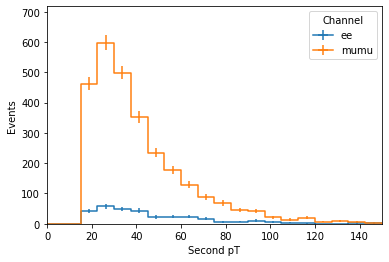

In [17]:
from coffea import hist

second_pt = hist.Hist("Events", 
                      hist.Cat(name='channel', label='Channel'), 
                      hist.Bin(name='pt2', label='Second pT', n_or_arr=20, lo=0, hi=150))

# For all event pts (:), get second index (1). Also, removed jagged structure to get flat array.
mumu_pt2 = mumu_channel.pt[:, 1].flatten()
ee_pt2 = ee_channel.pt[:, 1].flatten()

second_pt.fill(channel='mumu', pt2=mumu_pt2.flatten())
second_pt.fill(channel='ee', pt2=ee_pt2.flatten())

hist.plot1d(second_pt, overlay='channel')

[TODO: A more complicated example?]

<h2>Demo</h2>
<p>To top all of this, Coffea has tools that make scale-out easy. All we do is bundle everything we have done up until now inside of the 'process.ProcessorABC' class. This class allows our analysis to run simply across many files and to deploy on an executor. If you want to test this locally, the futures_executor is the easiest to use. I, however, will be giving a demo of the analysis deployed on a Dask cluster, the details of which were presented by Oksana Shadura earlier this week.</p>

<h2>Acknowledgements</h2>
<p>[TODO: Acknowledgements]</p>

In [18]:
end = time.time()
print(str(end - start))

801.3044056892395
